In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Fit the Z spectroscopy data to find the kappa constant
fit = polyfit(z_spec[:,0],log(abs(z_spec[:,1])),1)
kappa = fit[0] #kappa represents the semi-logarithmic slope value of the
               #  recorded current as the tip is withdrawn from the sample
#Current noise is estimated using Equation 2.16
cur_noise = exp(-kappa*(z_noise-mean(z_noise)))
#The current is removed from the measured data through division
#  *Dividing two exponents with the same base results in the 
#    exponents just being subtracted
#  **This alos means that the noise is removed from the measured data
#     independant of the initial current value in the measured data
#  ***This is a particularly useful trait in spectroscopic cancellation
#     where the initial current value changes with the sweeping voltage
cur_sig = cur_m/cur_noise #Equation 2.17
# *Equation 2.17 is also applied to cancel LIY data by estimating
#    the amount of noise in LIY and dividing it by the measured lIY

In [ ]:

def fit_cancel(array, n=2):
    '''
    **This function was modified from code written by Albert Chen
    Remove drift with a n-degree polynomial function fitted to the data
    
    Inputs:
        array - Required: 1D numpy array to be cancelled
        n     - Optional: degree of polynomial used for fitting
        
    Returns:
        Zero centered numpy array, same length as 'array'
    '''
    #Create a linearly seperated set of point to fit array with
    t = np.linspace(0,len(array),len(array)) 
    #Fit array using the numpy polyfit function and implement
    # the resuting coefficients into a polynomial object
    fit = poly1d(np.polyfit(t,array,n))
    #Calculate the corrective array using the fit object
    corrective = fit(t)
    #Return the corrected data
    return array - corrective

def avg_fft(data,n,o,b=5):
    '''
    The Fourier transform of the data, in entirety, is quite noisy.
    This function segments the data into manageable pieces and averages
      the Fourier transform of each segment together to reduce that noise. 
    This reduces incoherent signals and random flucuations in coherent ones.
    
    Inputs:
        data - Required: 1D numpy array of data to be segmented
        n    - Required: length of segment data is pieced into
        o    - Required: length of overlap between segments 
        b    - Optional: Beta parameter used by the Kaiser function;
                     the default = 5 makes it similar to a Hamming window
        fs   - Optional: int stating sampling rate of data collection
    
    Returns:
        seg  - fft of length n 
        freqs- frequencies the make up the fft
    '''
    #Initialize a 2D array with the number of rows being how many segments
    #   can be created from data of length 'n' and columns of length 'n'
    seg = np.zeros(((len(data)-o)//(n-o),n),dtype=np.complex)
    temp = np.copy(data)
    i = 0
    #Parce through data, seperating the segments into different rows
    #This does not utilize all the data, only up length divisible by n
    #Break out of the while loop once only the surplus data remains
    while len(temp) >= n:
        #Remove any dc offset or 2nd degree polynomial drift
        #  from the segmented data and save it to the designated row
        seg[i,:] = fit_cancel(temp[:n])
        i += 1 #iterate to the next row
        temp = temp[n-o:] #Redefine the data set, removing the last 
                          #  segmented piece of data minus the overlap
    #Calculate the Fourier transform of each row in the 2D array
    seg = fft.fft(seg,axis=1)
    #Average the Fourier transforms together
    seg = mean(seg,axis=0)
    #Calculate the corresponding frequencies 
    freqs = fft.fftfreq(len(seg),1/fs)
    return seg,freqs

def cal_alias(data,w_mod,n,o,b=5,fs=10000):
    '''
    Calibrate the transfer function needed to remove spectroscopic 
      aliasing from current and LIY data. This scheme is applied using 
      data collected while the system is in steady state and is applied
      in parallel to the vector cancellation scheme. It also is only
      needed for vector cancellation when the 'Exact Propogation' method
      is used (G-Z-I-LIY). When the 'Direct Propogation' method is used
      (G-I or G-LIY) aliasing is accounted for, though not 'properly'.
      
    Inputs:
        data  - Required: 1D array containing the current or LIY calibration data
        w_mod - Required: the frequency the voltage bias was modulated at
        n     - Required: length of segment data is pieced into
        o     - Required: length of overlap between segments 
        b     - Optional: Beta parameter used by the Kaiser function;
                     the default = 5 makes it similar to a Hamming window
        fs    - Optional: int stating sampling rate of data collection
    
    Returns:
        A     - Interpolated object representing the attenuation and phase shift 
                by frequencies shifted due to the modulation of the voltage bias
        freqs - The frequencies by which the transfer function A was calibrated
    '''
    #Initialize the array as a complex set of numbers 
    #   so it saves any phase information as well as magnitude
    A = np.zeros(len(n),dtype='complex128')
    #Calculate the Fourier transform of the data and clean
    #  it up with some averaging
    fft_dat,freqs = avg_fft(data,n,o,b=b)
    w_alias = int(2*w_mod/freqs[1]) #indicates the range of the aliasing effect
    #Iterate through positive frequencies up to 2*w_mod and calculate
    #  the response that the frequencies about w_mod have to detected frequencies
    #  less than w_mod. *Implementation of Equation 2.13
    for i,frq in enumerate(freqs[:w_alias]):
        A[i] = fft_dat[absolute(i-w_alias)]/fft_dat[i]
    #Interpolate the transfer function so that frequencies called between
    #  bins can be estimated 
    A = scipy.interpolate.interp1d(freqs,A,kind='linear',fill_value='extrapolate')
    
    return A,freqs

#Calibrate a transfer function between the vibration frequency peaks and
#   the corresponding aliased peaks
A,__ = cal_alias(cur_cal,1000,200000,50000,b=5,fs=10000)
#Take the Fourier transform of the measured current data
fft_cur_m = fft.fft(cur_test)
#Calculate the corresponding frequencies
freqs = fft.fftfreq(len(cur_test),1/10000) 
w_alias = int(2*w_mod/freqs[1]) #indicates the range of the aliasing effect
#Initialize the array for the aliased noise
cur_alias = np.zeros(len(cur_test),dtype='complex128')
#Iterate up to 2*w_mod to estimate the amount of noise that is the result 
#   of the aliasing effect *Implementation of Equation 2.14
for i in arange(w_alias):
    cur_alias[i] = A(absolute(freqs[w_alias-i]))*fft_cur_m[absolute(w_alias-i)]
#Ensure that the positive and negative frequencies of the aliased noise are 
#   complex conjugates *Following the conditions of Equation 2.14 
cur_alias[int(len(cur_alias)/2):] = np.flip(
    conj(cur_alias[:int(len(cur_alias)/2)]))
#Move the aliased noise back into the time domain *Equation 2.15
cur_alias = fft.ifft(cur_alias)
    
    
fft_c = fft.fft(liy_cal[int(200*fs):int(201*fs)])
frq_c = np.fft.fftfreq(len(fft_c),1/10000)
print(np.where(frq_c==w_mod))

# print(frq_c[1],freqs[1])

for i,frq in enumerate(freqs[:int(len(seg_c)/2)]):
    A[i] = seg_c[absolute(i-1000)]/seg_c[i]
A = scipy.interpolate.interp1d(freqs,A,kind='linear',fill_value='extrapolate')
# A[int(len(seg_c)/2):] = np.flip(conj(A[:int(len(seg_c)/2)]))
c_alias = np.zeros(len(seg_c),dtype='complex128')
for i in arange(int(2*w_mod)):
    c_alias[i] = A(absolute(frq_c[1000]-frq_c[i]))*fft_c[absolute(1000-i)]
c_alias[int(len(seg_c)/2):] = np.flip(conj(c_alias[:int(len(seg_c)/2)]))

In [4]:
A = np.zeros(20,dtype='complex128')


(1+0j)


(2, 120000)


(0, 100)

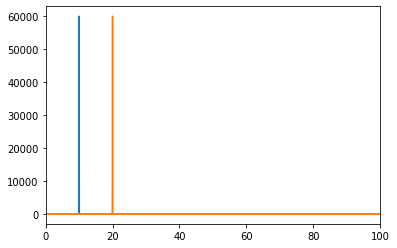

In [15]:
t= linspace(0,12,120000)
x = np.zeros((2,len(t)))
x[0,:] = sin(10*2*pi*t)
x[1,:] = sin(20*2*pi*t)
fft_x = fft.fft(x,axis=1)
freq = fft.fftfreq(len(x[0,:]),1/10000)
plot(freq,absolute(fft_x[0,:]))
plot(freq,absolute(fft_x[1,:]))
print(shape(fft_x))
xlim(0,100)

In [19]:
print(freq[10000])
print(freq[int(2*1000/freq[1])])

833.3333333333333
2000.0
